<a href="https://colab.research.google.com/github/yaobviously/NBADFS/blob/main/nbadfs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install category_encoders --quiet
!pip install shap --quiet
!pip install requests --quiet
!pip install beautifulsoup4 --quiet
!pip install fuzzywuzzy --quiet
!pip install scikit-garden --quiet

     |████████████████████████████████| 80 kB 2.8 MB/s 
     |████████████████████████████████| 356 kB 5.2 MB/s 
     |████████████████████████████████| 317 kB 5.0 MB/s 


Looking this over, it needs to be reorganized with my newfound skills! But it works well and predicting quantiles is the key insight to gain an edge on the field. 

Quantile loss functions can be used to train neural networks to do the same, but
they do not outperform the random forests until the dataset is large. That said, I should get more data and run the tests myself.

In [18]:
thisyear = '/content/drive/MyDrive/NBA Player Box Scores/nba_2021_boxscores.csv'

# i'd load the daily slate right here
slate = '/content/drive/MyDrive/slatemay3.csv'

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
import joblib
import requests
from fuzzywuzzy import process
from bs4 import BeautifulSoup
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from xgboost import XGBRegressor
from skgarden import RandomForestQuantileRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
from xgboost import plot_importance

Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
The sklearn.tree.tree module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.tree. Anything that cannot be imported from sklearn.tree is now part of the private API.


In [7]:
def wrangle(url):
    
    
    df = pd.read_csv(url,
                     parse_dates = ['DATE'],
                     index_col = 'DATE')
    
    df = df.rename(columns={'BIGDATABALL\nDATASET' : 'game_type',
                            'GAME-ID' : 'gameid',                            
                            'PLAYER-ID' : 'playerid',
                            'PLAYER \nFULL NAME' : 'player',
                            'POSITION' : 'position',
                            'OWN \nTEAM' : 'team', 
                            'OPPONENT \nTEAM' : 'opponent',
                            'VENUE\n(R/H)' : 'venue',
                            'STARTER\n(Y/N)' : 'starter',
                            'USAGE \nRATE (%)' : 'usage',
                            'DAYS\nREST' : 'rest',
                            'TOT' : 'totreb'})
    
    df.columns = df.columns.str.lower()
    
    df['starter'] = [1 if start == 'Y' else 0 for start in df['starter']]
    df['venue'] = df.venue.map({'H' : 1, 'R' : 0})
    df['month'] = pd.DatetimeIndex(df.index).month

    # computing bonus points for double-doubles and triple-doubles
    
    df['dbl_digits'] = (df[['pts', 'a', 'totreb', 'st', 'bl']] >= 10).astype(int).sum(axis=1)    
    df['bonus'] = 0
    df['bonus'].loc[df['dbl_digits'] == 2] = 1.5    
    df['bonus'].loc[df['dbl_digits'] == 3] = 4.5
    
    # computing player fantasy points and game rate
    df['playerfp'] = (df['pts'] + \
                      df['a'] * 1.5 + \
                      df['totreb'] * 1.25 + \
                      df['st'] * 2 + \
                      df['bl'] * 2 + \
                      df['3p'] * 0.5 + \
                      df['to'] * -0.5 + \
                      df['bonus']
                      )
    df['gamefp36'] = ((df['playerfp'] / df['min']) * 36).round(1)
    
    # computing rolling team fantasy points
    
    df['teamfp'] = df.groupby(['gameid', 'team'])['playerfp'].transform(sum)
    
    tm21 = df.groupby(['gameid', 'team'], as_index = False).agg(teamfp = ('playerfp', 'sum'),
                                                                teammin = ('min', 'sum')).drop_duplicates()

    opp21 = df.groupby(['gameid', 'opponent'], as_index = False).agg(oppfp = ('playerfp', 'sum'),
                                                                     oppmin = ('min', 'sum')).drop_duplicates()

    tm21['totteamfp'] = tm21.groupby('team')['teamfp'].transform(lambda x: x.expanding().sum().shift())
    tm21['totteammin'] = tm21.groupby('team')['teammin'].transform(lambda x: x.expanding().sum().shift())
    tm21['fp48'] = (tm21['totteamfp'] / tm21['totteammin']) * 240
    tmdf = tm21[['gameid', 'team', 'fp48']].copy()

    df = df.reset_index().merge(tmdf, how = 'left', on = ['gameid', 'team']).set_index('DATE')

    # computing rolling defense stats

    opp21 = df.groupby(['gameid', 'opponent'], as_index = False).agg(opponent_fp = ('playerfp', 'sum'),
                                                                 opponent_min = ('min', 'sum'))

    opp21['totoppfp'] = opp21.groupby('opponent')['opponent_fp'].transform(lambda x: x.expanding().sum().shift())
    opp21['totoppmin'] = opp21.groupby('opponent')['opponent_min'].transform(lambda x: x.expanding().sum().shift())
    opp21['oppfp48'] = (opp21['totoppfp'] / opp21['totoppmin']) * 240
    oppdf = opp21[['gameid', 'opponent', 'oppfp48']]

    df = df.reset_index().merge(oppdf, how = 'left', on = ['gameid', 'opponent']).set_index('DATE')
    
    # computing running and rolling averages for players

    df['gamesplayed'] = df.groupby('player')['gameid'].cumcount().shift()
    df['avgfp'] = df.groupby('player')['playerfp'].transform(lambda x: x.expanding().mean().shift())
    df['avgfga'] = df.groupby('player')['fga'].transform(lambda x: x.expanding().mean().shift())   
    df['totmin'] = df.groupby('player')['min'].transform(lambda x: x.cumsum().shift())
    df['totfp'] = df.groupby('player')['playerfp'].transform(lambda x: x.cumsum().shift())
    df['seasonfppm'] = (df['totfp'] / df['totmin']).round(2)
    df['ptsseason'] = df.groupby('player')['pts'].transform(lambda x: x.expanding().sum().shift())
    df['ftaseas'] = df.groupby('player')['fta'].transform(lambda x: x.expanding().sum().shift())
    df['fgaseas'] = df.groupby('player')['fga'].transform(lambda x: x.expanding().sum().shift())
    df['3paseas'] = df.groupby('player')['3pa'].transform(lambda x: x.expanding().sum().shift())
    df['3fraction'] = df['3paseas']/df['fgaseas']
    df['starter_avg'] = df.groupby('player')['starter'].transform(lambda x: x.expanding().mean().shift())
    df['starter_diff'] = df['starter'] - df['starter_avg']
    
    df['ts_season'] = (df['ptsseason'] / (2 * (df['fgaseas'] + (df['ftaseas'] * 0.44)))).round(3)
    
    df['mpg'] = df.groupby('player')['min'].transform(lambda x: x.expanding().mean().shift())
    df['rollingmpg'] = df.groupby('player')['min'].transform(lambda x:
                                                             x.rolling(3, min_periods = 1)
                                                             .mean()
                                                             .shift())
    
    df['avgusage'] = df.groupby('player')['usage'].transform(lambda x:
                                                             x.expanding()
                                                             .mean()
                                                             .shift())
    
    df['rollingusage'] = df.groupby('player')['usage'].transform(lambda x:
                                                                 x.rolling(5)
                                                                 .mean()
                                                                 .shift())  
    
    df['stdgamefp'] = df.groupby('player')['gamefp36'].transform(lambda x:
                                                                 x.expanding()
                                                                 .std()
                                                                 .shift())  
    
    df['maxfp'] = df.groupby('player')['playerfp'].transform(lambda x: x.expanding().max().shift())
    df['rollingmaxfp'] = df.groupby('player')['playerfp'].transform(lambda x: x.rolling(5).max().shift())
    df['maxmin'] = df.groupby('player')['min'].transform(lambda x: x.rolling(8).max().shift())
    df['minmin'] = df.groupby('player')['min'].transform(lambda x: x.rolling(8).min().shift())    
    df['extramins'] = df['rollingmpg'] - df['mpg']
    df['extrausage'] = df['rollingusage'] - df['avgusage']
    df['league3p'] = df['3p'].expanding().sum().shift()
    df['league3pa'] = df['3pa'].expanding().sum().shift()
    df['league3perc'] = (df['league3p'] / df['league3pa']).round(3)
    
    df['starter_avg'] = df.groupby('player')['starter'].transform(lambda x: x.expanding().mean().shift())
    df['starter_diff'] = df['starter'] - df['starter_avg']
    df['did_boom'] = (df['playerfp'] >= (df['avgfp'] + 8)).astype(int)
    df['above_avg'] = (df['playerfp'] > df['avgfp']).astype(int)

    # calculating starter stats
    df['gamestartersum'] = df.groupby(['gameid', 'team', 'starter'])['starter_avg'].transform(sum)
    df['oppstartersum'] = df.groupby(['gameid', 'opponent', 'starter'])['starter_avg'].transform(sum)
    df['starterfpgame'] = df.groupby(['gameid', 'team', 'starter'])['avgfp'].transform(sum)
    df['starterfraction'] = df['starterfpgame'] / df['fp48']
    # dropping colums i don't need 
    
    col_drop = ['dbl_digits', 'playerid', 'ptsseason', 'ftaseas','fgaseas',
                'league3p', 'league3pa', '3paseas']   

    df.drop(col_drop, axis = 1, inplace = True)
    
    return df

In [8]:
df = wrangle(thisyear)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [9]:

game_stats = ['min', 'fg', 'fga', '3p', '3pa', 'ft', 'fta', 'or', 'dr',
              'totreb', 'a', 'pf', 'st', 'to', 'bl', 'pts', 'usage',
              'bonus', 'teamfp', 'gameid', 'game_type',
              'gamefp36', 'above_avg', 'playerfp']

# the model features. total starter fp/game is a feature with value that's understood
# but not fully

model_cols = ['avgfp', 'starter', 'extramins', 'rollingmaxfp', 'starter_diff',
            'seasonfppm', 'starterfpgame', 'oppfp48', 'playerfp', 'stdgamefp'        
                                       
            
            ]

df_model = df[model_cols]

In [10]:
# In this cell we specify the target and divide the data set into the train and
# test sets using a date threshold

target = 'playerfp'

date_threshold = '2021-03-01'
mask = df_model.index < date_threshold

X = df_model.drop(target, axis = 1)
y = df_model[target]

X_train, y_train = X[mask], y[mask]
X_test, y_test = X[~mask], y[~mask]

In [11]:
baseline = mean_squared_error(y_test, X_test['avgfp'].fillna(method = 'bfill'))

print('The mean squared error using only player average fp to date is:', baseline)

The mean squared error using only player average fp to date is: 103.8001635393614


In [13]:
# training an xgboost model to predict the mean expected score

model_xg = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy = 'mean'),
    XGBRegressor(eval_metric = 'rmse',
                 n_estimators = 75,
                 max_depth = 3
                 )
)

model_xg.fit(X_train, y_train)

# getting the features name - will be used to predict
features = model_xg.named_steps['ordinalencoder'].get_feature_names()

mean_squared_error(y_test, model_xg.predict(X_test))

[15:03:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


94.74443918982443

In [14]:
features = model_xg.named_steps['ordinalencoder'].get_feature_names()

In [ ]:
# training the RF quantile forest with the optimized parameters (from other runs)

model_q = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestQuantileRegressor(n_estimators = 175,
                                  min_samples_leaf = 10)
)

model_q.fit(X_train, y_train);

In [16]:
# retraining the xgboost model to get the shapley plots

encoder = OrdinalEncoder()
imputer = SimpleImputer()
booster = XGBRegressor(eval_metric = 'rmse',
                        n_estimators = 100,
                        learning_rate = 0.1)

X_test_encoded = encoder.fit_transform(X_test)
X_test_imputed = imputer.fit_transform(X_test_encoded)
X_imp_df = pd.DataFrame(X_test_imputed, columns = X_test.columns)

booster.fit(X_test_imputed, y_test)

explainer = shap.TreeExplainer(booster)
shap_values = explainer.shap_values(X_test_imputed)

[15:09:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


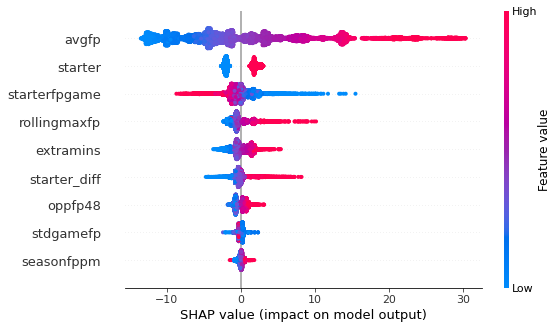

In [17]:
shap.summary_plot(shap_values,
                  X_imp_df,
                  )

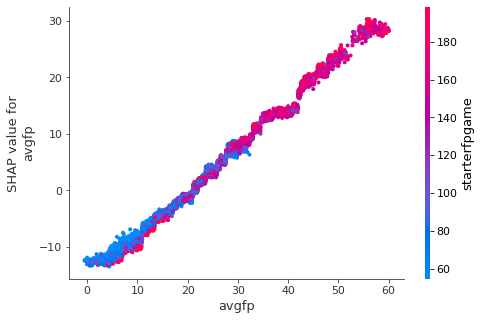

In [ ]:
shap.dependence_plot('avgfp',
                     shap_values,
                     X_imp_df)

In [19]:
# transforming the fantasy cruncher csv file into a format that allows me to 
# use my FP Projection model to project FP

slate = pd.read_csv(slate)
slate.columns = slate.columns.str.lower()

slate['opp'] = slate['opp'].str.lstrip('@').str.lstrip('vs ')

fcteamdict = {'ATL' : 'Atlanta', 'BOS':'Boston', 'BKN': 'Brooklyn', 'CHA' : 'Charlotte',
                   'WAS' : 'Washington', 'POR':'Portland', 'CHI':'Chicago',
                   'HOU' : 'Houston', 'DET':'Detroit', 'CLE':'Cleveland',
                   'DEN':'Denver', 'DAL':'Dallas', 'IND':'Indiana', 
                   'MEM':'Memphis', 'MIA':'Miami', 'MIL':'Milwaukee',
                   'NOP':'New Orleans', 'NYK':'New York', 'ORL':'Orlando',
                   'PHI':'Philadelphia', 'PHX': 'Phoenix', 'SAS':'San Antonio',
                   'TOR':'Toronto', 'UTA':'Utah', 'SAC':'Sacramento',
                   'MIN':'Minnesota', 'OKC':'Oklahoma City', 'GSW':'Golden State', 
                   'LAL': 'LA Lakers', 'LAC' : 'LA Clippers'}

slate['opp'] = slate['opp'].map(fcteamdict)

slate = slate[['player', 'team', 'opp', 'proj mins', 'own']].copy()
slate = slate[slate['proj mins'] >= 0.5].copy()

In [20]:
playerdict = {'Guillermo Hernangomez' : 'Willy Hernangomez', 'J.J. Redick' : 'JJ Redick',
              'James Ennis' : 'James Ennis III', 'Robert Williams' : 'Robert Williams III',
              'Marcus Morris' : 'Marcus Morris Sr.', 'DeAndre Bembry' : "DeAndre' Bembry",
              'PJ Washington' : 'P.J. Washington', 'Raulzinho Neto' : 'Raul Neto', 
              'Mohamed Bamba' : 'Mo Bamba', 'Bruce Brown Jr.' : 'Bruce Brown', 
              'Danuel House' : 'Danuel House Jr.', 'Juan Hernangomez' : 'Juancho Hernangomez',
              'Patrick Mills' : 'Patty Mills', 'Kevin Knox' : 'Kevin Knox II',
              'Otto Porter' : 'Otto Porter Jr.', 'C.J. McCollum' : 'CJ McCollum', 
              'KJ Martin Jr.' : 'Kenyon Martin Jr.', 'Ishmael Smith' : 'Ish Smith',
              'Harry Giles' : 'Harry Giles III', 'Charlie Brown' : 'Charlie Brown Jr.',
              'Wesley Iwundu' : 'Wes Iwundu', 'TJ Leaf' : 'T.J. Leaf',
              'Troy Brown' : 'Troy Brown Jr.', 'Didi Louzada Silva' : 'Didi Louzada',
              'Cristiano Da Silva Felicio' : 'Cristiano Felicio'              
              }

slate['player'] = slate['player'].map(playerdict).fillna(slate['player'])

players_today = slate[slate['proj mins'] >= 0.5]['player'].unique()
features_needed = features + ['player', 'mpg', 'starter_avg']

latest_stats = df[df['player'].isin(players_today)].groupby('player',as_index = True)[features_needed].tail(1)

In [21]:
# calculates extra expected minutes from FantasyCruncher ProjMins. next year
# i'll do my own. this cell also outputs a set of players that are missing
# which means i have to add them to my dict

df_cruncher = pd.merge(slate, latest_stats, how = 'left', on = 'player')
df_cruncher['extramins'] = df_cruncher['proj mins'] - df_cruncher['mpg']

print(set(players_today).difference(set(latest_stats['player'])))

set()


In [ ]:
""" Get the starters from Rotowire """

roto = requests.get('https://www.rotowire.com/basketball/nba-lineups.php')
soup = BeautifulSoup(roto.content)

starters = []

for s in soup.find_all('li', class_ = 'lineup__player is-pct-play-100'):
  s = str(s)
  starters.append(s.split(">")[4].replace('</a',''))

matches = []

for starter in starters:
  h = process.extract(starter, df_cruncher['player'].unique())
  matches.append(h[0][0])

In [22]:
# general corrections to what's returned above. rotowire turned out to be 
# unreliable on a few occasions! 

df_cruncher['min_rank'] = df_cruncher.groupby('team')['proj mins'].rank("dense", ascending = False)
# df_cruncher['starter'] = [1 if player in matches else 0 for player in df_cruncher['player']]
df_cruncher['starter'] = [1 if min >= 26 else 0 for min in df_cruncher['proj mins']]
df_cruncher['starter_diff'] = df_cruncher['starter'] - df_cruncher['starter_avg']

In [23]:
players_to_start = ['Grant Williams', 'Justin Holiday', "DeAndre' Bembry", 'Keldon Johnson',
                    'Dejounte Murray']

players_to_unstart = []

def start(df, player):
  df.loc[df['player'] == player, 'starter'] = 1
  
def unstart(df, player):
  df.loc[df['player'] == player, 'starter'] = 0

[start(df_cruncher, player) for player in players_to_start]
[unstart(df_cruncher, player) for player in players_to_unstart]

[]

In [24]:
latest_defense = df.groupby('opponent', as_index = True)[['opponent','oppfp48']].tail(1)
df_cruncher = pd.merge(df_cruncher, latest_defense, how = 'left', left_on = 'opp', right_on = 'opponent')
df_cruncher = df_cruncher.drop(columns = ['min_rank', 'oppfp48_x', 'starter_avg', 'opponent'])
df_cruncher = df_cruncher.rename(columns = {'oppfp48_y' : 'oppfp48'})

In [ ]:
df_cruncher['starterfpgame'] = df_cruncher.groupby(['team','starter'])['avgfp'].transform(lambda x: x.sum())

In [25]:
# df_cruncher = df_cruncher[df_cruncher['proj mins'] >= 0.5].copy()
df_cruncher['model_proj'] = model_xg.predict(df_cruncher[features])
df_cruncher['80th_percentile'] = (model_q.predict(df_cruncher[features], quantile = 80)).round(1)
df_cruncher['model_proj'] = (df_cruncher['model_proj']).round(1)

In [26]:
df_cruncher[['player', 'model_proj', '80th_percentile']].sort_values(by = 'model_proj', ascending = False).head(25)

,player,model_proj,80th_percentile
0,Russell Westbrook,57.900002,67.4
14,Nikola Jokic,52.200001,64.2
49,Joel Embiid,51.599998,63.0
3,Stephen Curry,50.700001,60.4
4,Domantas Sabonis,49.400002,61.2
12,Nikola Vucevic,49.099998,56.5
2,Damian Lillard,47.700001,58.2
36,Trae Young,46.900002,58.5
7,Bradley Beal,46.599998,55.8
6,Julius Randle,46.500000,55.5
